In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from utils import FilePath, DMReader
from psm.image import preprocess
from bm3d import bm3d
from skimage.restoration import rolling_ball
from scipy.spatial import Voronoi
from voronoi import *
import seaborn as sns
import seaborn_image as isns
from atoms import *
from psm.image.peaks import find_local_peaks
from psm.image import refine_peaks, Polynomial2D
from RDF import *

plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率

In [2]:
path = FilePath()
images, pixSizes = DMReader(path)

Now,b get 6 files
('C:/Users/zhuch/Messy Tasks/NAM/CrxW1-xS2_Gradient/Selected/20200723 1342 STEM Diffraction HAADF 5.5 Mx_HAADF.dm3', 'C:/Users/zhuch/Messy Tasks/NAM/CrxW1-xS2_Gradient/Selected/20200723 1347 STEM Diffraction HAADF 5.5 Mx_HAADF.dm3', 'C:/Users/zhuch/Messy Tasks/NAM/CrxW1-xS2_Gradient/Selected/20200723 1351 STEM Diffraction HAADF 5.5 Mx_HAADF.dm3', 'C:/Users/zhuch/Messy Tasks/NAM/CrxW1-xS2_Gradient/Selected/20200723 1356 STEM Diffraction HAADF 5.5 Mx_HAADF.dm3', 'C:/Users/zhuch/Messy Tasks/NAM/CrxW1-xS2_Gradient/Selected/20200723 1359 STEM Diffraction HAADF 5.5 Mx_HAADF.dm3', 'C:/Users/zhuch/Messy Tasks/NAM/CrxW1-xS2_Gradient/Selected/20200723 1404 STEM Diffraction HAADF 5.5 Mx_HAADF.dm3')
We got 6 images here.


In [3]:
_img = [np.array(img).astype(float) for img in images]
_img = [preprocess.normalize_range(img) for img in images]
_img = [preprocess.remove_hot_pixels(img) for img in images]
filtered = [bm3d(img, 40) for img in _img]
bkg = [rolling_ball(img, radius=15) for img in filtered]
img_sbkg = [fi - bg for fi, bg in zip(filtered, bkg)]
unrefined_peaks = [find_local_peaks(img, min_distance=16, local_threshold=.5, exclude_border=1, exclude_adjacent=True) for img in filtered]

model = Polynomial2D()
peaks = [refine_peaks(img, u_peaks, model=model, extent=3, progress_bar=True) for img, u_peaks in zip(img_sbkg, unrefined_peaks)]

atom_collections = [Atoms(i) for i in peaks]#turn coordinates and labels into Atoms
clusters = [clustering(i) for i in atom_collections] # making Atoms into clusters mode
for j in clusters:
    j.partition(20) # define every single clusters
centroids_collections = [cluster.centroids for cluster in clusters]
clusterNumber_collections = [cluster.clustersNumber for cluster in clusters]



 [||||||||||||||||||||] 94/94 fits


In [4]:
vor = [Voronoi(centroids) for centroids in centroids_collections]

In [5]:
c1 = clusters[0]

In [24]:
sizes = [len(i) for i in unrefined_peaks]

(0.0, 1024.0)

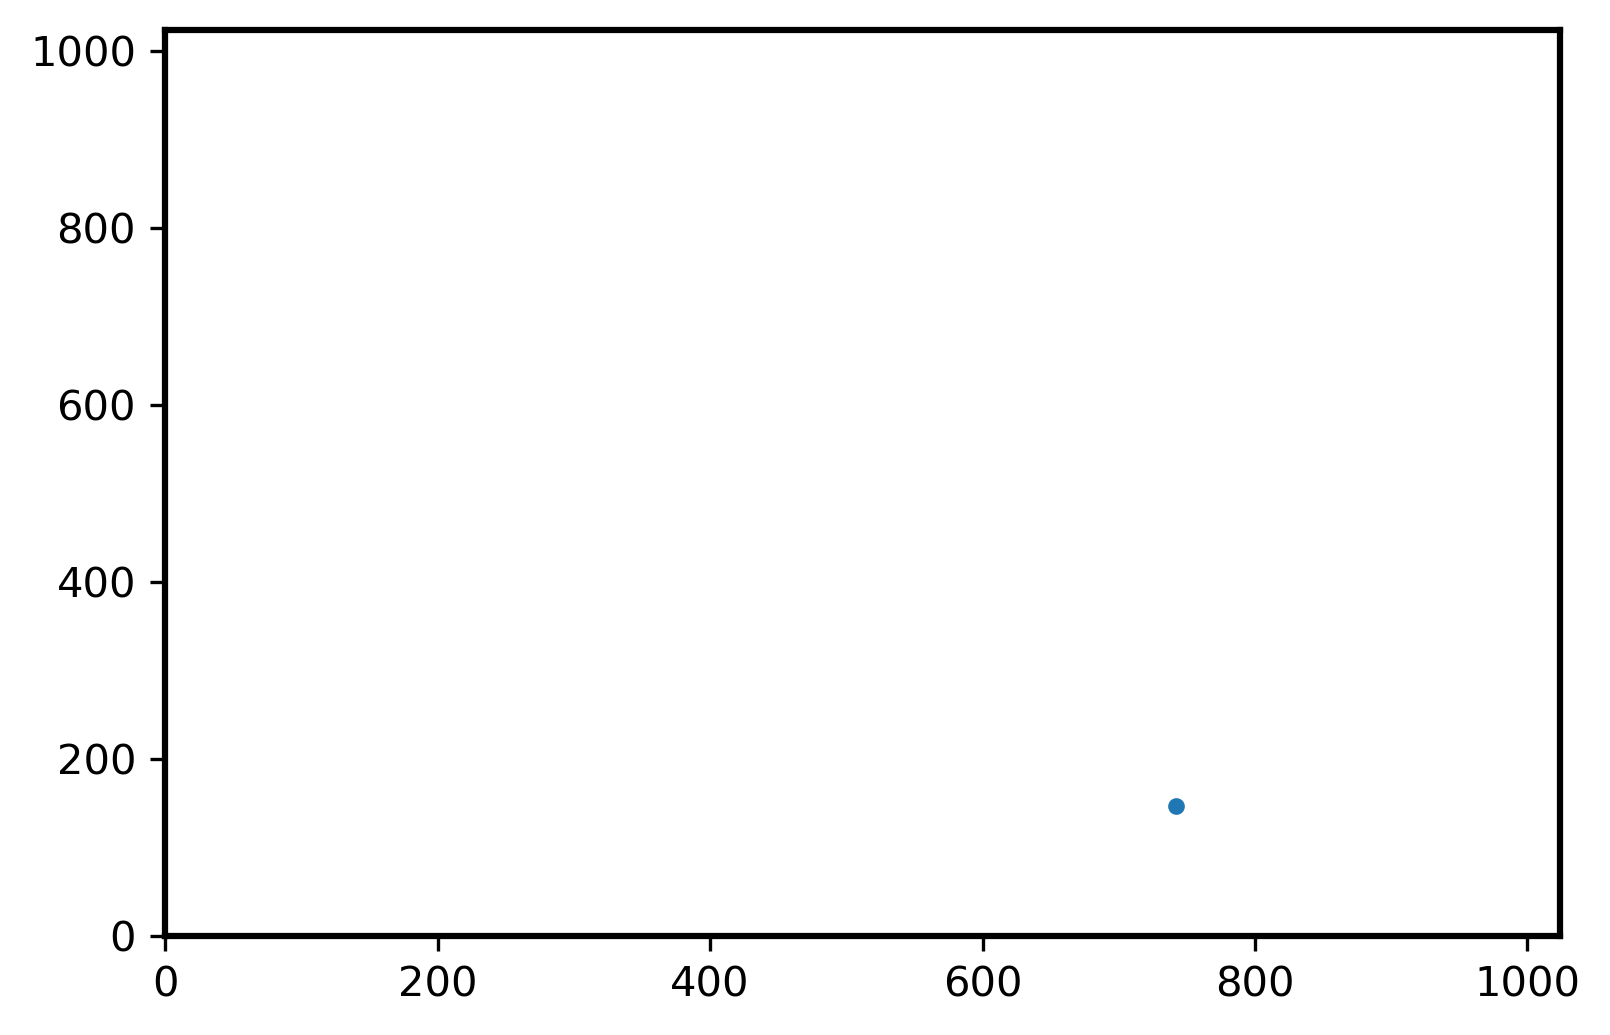

In [19]:
p = [i.coordinate for i in c1.clusters[17]]
p = np.array(p)
plt.scatter(p[:,0],p[:,1], marker='.')
plt.xlim([0,1024])
plt.ylim([0,1024])

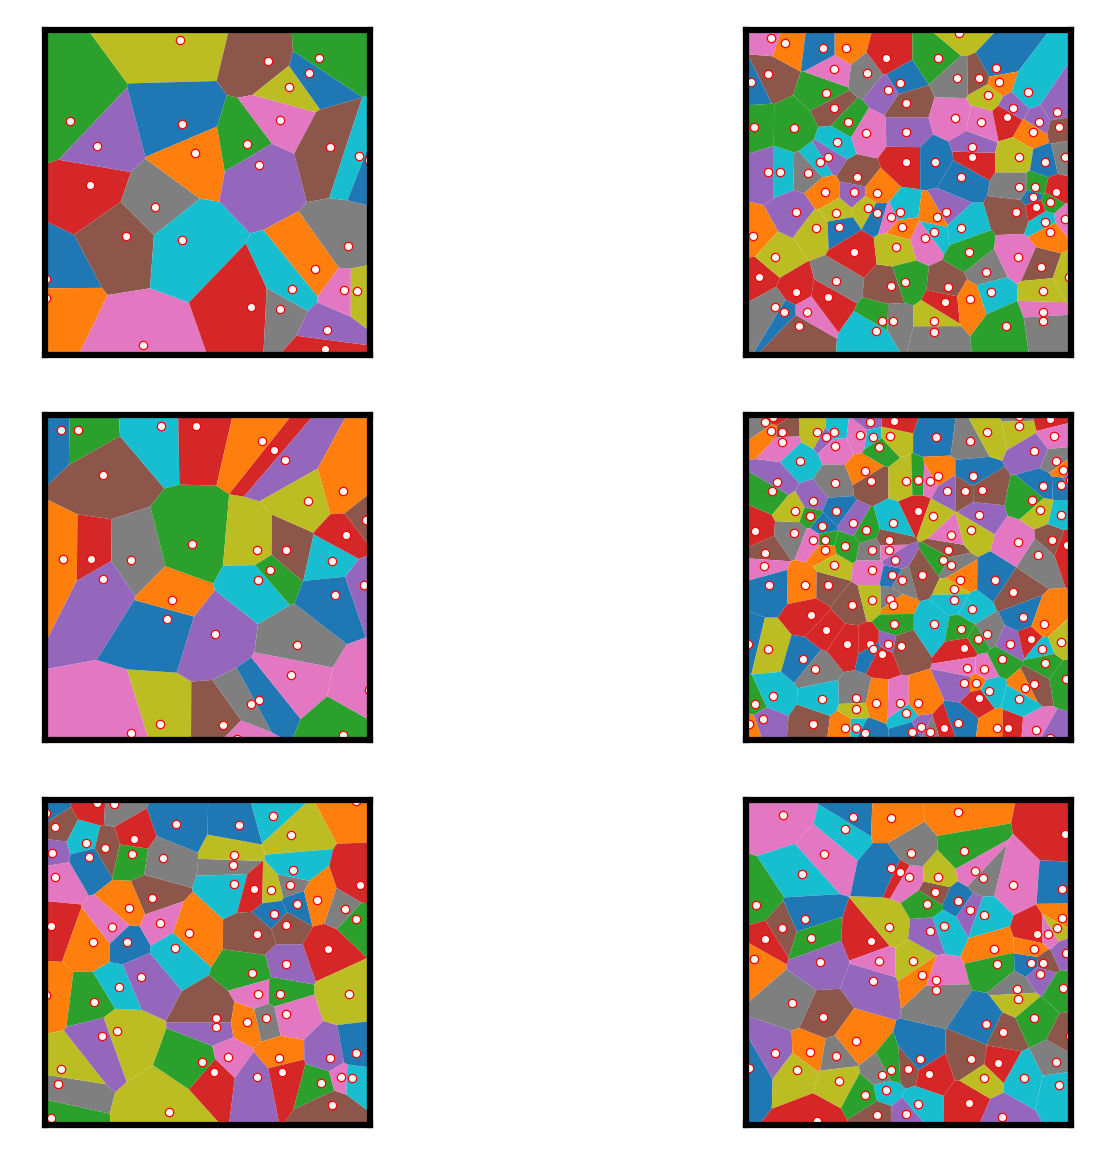

In [50]:
fig = plt.figure()
n = 1
for v, centroids in zip(vor, centroids_collections):
    plot_pos = int(str(32) + str(n))
    regions, vertices = voronoi_finite_polygons_2d(v)
    ax = fig.add_subplot(plot_pos)
    #ax.axis('equal')
    n += 1
    # colorize
    for region in regions:
        polygon = vertices[region]
        ax.fill(*zip(*polygon), alpha=1)
    ax.plot(centroids[:,0], centroids[:,1], 'o', ms=2, mfc='w', mec='r', mew=.3)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0, 1024)
    ax.set_ylim(0, 1024)
    #ax.set_xlim(v.min_bound[0] - 0.1, v.max_bound[0] + 0.1)
    #ax.set_ylim(v.min_bound[1] - 0.1, v.max_bound[1] + 0.1)
    ax.set_aspect(1)
fig.tight_layout()
